# A RNN-volatility model failed attemp

This notebook contains some results on volatility modeling for financial time series. The aim is to build a model for volatility such that the normalized innovations are Gaussian.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Download the S&P 500 daily price time series, compute and display its returns.

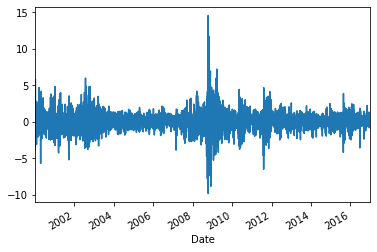

In [2]:
import datetime as dt
import pandas_datareader as pdr

start = dt.datetime(2000,1,1)
end = dt.datetime(2017,1,1)
sp500 = pdr.get_data_yahoo('SPY', start=start, end=end)
returns = 100*sp500['Close'].pct_change().dropna()
returns.plot()
plt.show()

## GARCH model

We first calibrate the GARCH(1,1) model on this dataset.

Iteration:      1,   Func. Count:      5,   Neg. LLF: 6063.783452067871
Iteration:      2,   Func. Count:     12,   Neg. LLF: 6058.215159265908
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6058.052981830684
Iteration:      4,   Func. Count:     25,   Neg. LLF: 6055.7357429607055
Iteration:      5,   Func. Count:     31,   Neg. LLF: 6054.91580157709
Iteration:      6,   Func. Count:     37,   Neg. LLF: 6053.639713766643
Iteration:      7,   Func. Count:     43,   Neg. LLF: 6053.495483364422
Iteration:      8,   Func. Count:     48,   Neg. LLF: 6053.487194830668
Iteration:      9,   Func. Count:     53,   Neg. LLF: 6053.486949940124
Iteration:     10,   Func. Count:     58,   Neg. LLF: 6053.486947480184
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6053.4869474789375
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
                       Zero Mean - GARCH Model Results               

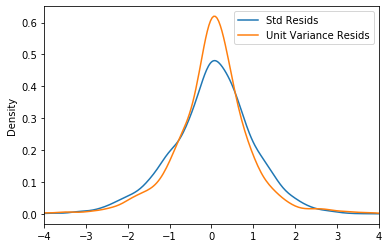

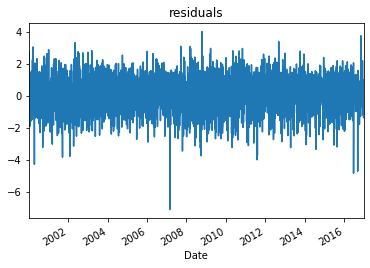

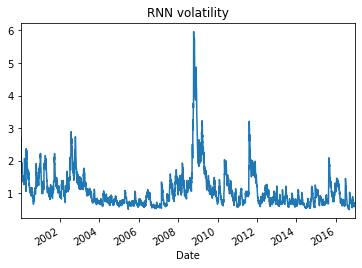

In [3]:
from arch import arch_model
from statsmodels.graphics.gofplots import qqplot

model_garch = arch_model(returns, mean='Zero', vol='GARCH', p=1, q=1)
res = model_garch.fit()
print(res.summary())

std_resid = res.resid / res.conditional_volatility
unit_var_resid = res.resid / res.resid.std()
df = pd.concat([std_resid, unit_var_resid], 1)
df.columns = ['Std Resids', 'Unit Variance Resids']
subplot = df.plot(kind='kde', xlim=(-4, 4))
plt.show()

std_resid.plot()
plt.title("residuals")
plt.show()

res.conditional_volatility.plot()
plt.title("RNN volatility")
plt.show()

## RNN

A custom layer is built to compute the negative log-likelihood. 

Note that you need to install the following dependency: `pip3 install tensorflow-probability==0.7`.

In [5]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input, Layer, Dense, SimpleRNN
from tensorflow.keras.models import Sequential, Model

class NegativeLogLikelihood(Layer):

    def __init__(self, n, **kwargs):
        self.n = n 
        super(NegativeLogLikelihood, self).__init__(**kwargs)
    
    def call(self, inputs):
        resi = tf.divide(tf.reshape(inputs[0], [-1, self.n]),
                         tf.reshape(inputs[1], [-1, self.n]))
        dist = tfp.distributions.Normal(loc=0.0, scale=1.0)
        return -1.0 * dist.log_prob(resi)

ImportError: This version of TensorFlow Probability requires TensorFlow version >= 1.15; Detected an installation of version 1.14.0. Please upgrade TensorFlow to proceed.

Now we build the model.

In [88]:
n = len(returns) - 1
input_x = Input(shape=(n,1))
input_y = Input(shape=(n))

hdim = 5
h1 = SimpleRNN(hdim, return_sequences=True, activation="relu")(input_x)
sig = Dense(1, activation="softplus")(h1) ## to get a positive output
loss = NegativeLogLikelihood(n)([input_y, sig])

def identity_loss(y_true, loss):
    return loss

model = Model(inputs=[input_x, input_y], outputs=[sig, loss])

model.compile(loss=identity_loss, 
              loss_weights=[0., 1.],
              optimizer="Adam"
              )

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 4275, 1)]    0                                            
__________________________________________________________________________________________________
simple_rnn_12 (SimpleRNN)       (None, 4275, 5)      35          input_25[0][0]                   
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 4275, 1)      6           simple_rnn_12[0][0]              
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 4275)]       0                                            
____________________________________________________________________________________________

Train the model.

In [89]:
## prepare the data
X, y = returns[0:n].values, returns[1:].values

input_x = [X.reshape((1,n,1)), y.reshape((1,n))] 
input_y= [np.zeros((1,n,1)), np.zeros((1,n))]

## train
history = model.fit(x=input_x, y=input_y, epochs=20)

Epoch 1/20
1/1 [==============================] - 1s 676ms/sample - loss: 1.2373 - dense_12_loss: 1.4619 - negative_log_likelihood_11_loss: 1.2373
Epoch 2/20
1/1 [==============================] - 0s 481ms/sample - loss: 1.2249 - dense_12_loss: 1.4955 - negative_log_likelihood_11_loss: 1.2249
Epoch 3/20
1/1 [==============================] - 0s 485ms/sample - loss: 1.2125 - dense_12_loss: 1.5314 - negative_log_likelihood_11_loss: 1.2125
Epoch 4/20
1/1 [==============================] - 0s 476ms/sample - loss: 1.2000 - dense_12_loss: 1.5699 - negative_log_likelihood_11_loss: 1.2000
Epoch 5/20
1/1 [==============================] - 0s 450ms/sample - loss: 1.1875 - dense_12_loss: 1.6111 - negative_log_likelihood_11_loss: 1.1875
Epoch 6/20
1/1 [==============================] - 0s 495ms/sample - loss: 1.1752 - dense_12_loss: 1.6551 - negative_log_likelihood_11_loss: 1.1752
Epoch 7/20
1/1 [==============================] - 1s 539ms/sample - loss: 1.1629 - dense_12_loss: 1.7028 - negative_lo

Display the (not good) results.

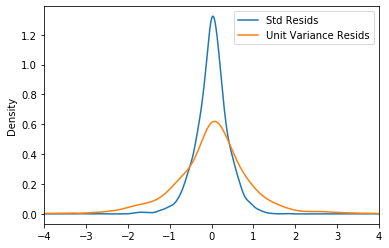

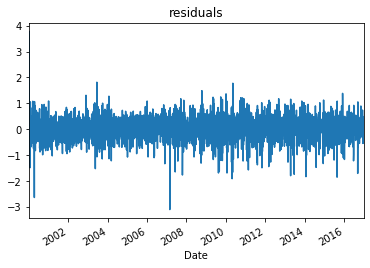

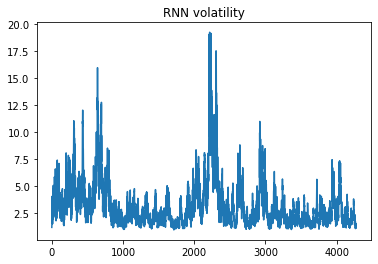

In [90]:
sigma, loss = model.predict(input_x)

res = pd.DataFrame({
        'conditional_volatility' : sigma.squeeze(),
        'resid' : y.squeeze()
        })

std_resid = res.resid / res.conditional_volatility
unit_var_resid = res.resid / res.resid.std()
df = pd.concat([std_resid, unit_var_resid], 1)
df.columns = ['Std Resids', 'Unit Variance Resids']
subplot = df.plot(kind='kde', xlim=(-4, 4))
plt.show()

std_resid.index=returns.index[1:]
std_resid.plot()
plt.title("residuals")
plt.show()

plt.plot(sigma.squeeze())
plt.title("RNN volatility")
plt.show()